Simranjit Bhella \
11/27/23 \
CS 410 \
Final Project: Fine-tuning GPT2 on QQP

In [0]:
!pip install transformers
!pip install pandas
!pip install torch
!pip install scikit-learn

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
import torch

from transformers import GPT2Tokenizer, GPT2Model, GPT2ForSequenceClassification, GPT2Config, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


2023-11-28 03:33:56.419453: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 03:33:57.255072: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 03:33:57.255114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 03:33:57.259970: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 03:33:57.690309: I tensorflow/core/platform/cpu_feature_g

# Data Preprocessing

In [0]:


def preprocess_data(file_path):
    data = pd.read_csv(file_path, sep='\t')

    # Sample 10% of the data
    data_sampled = data.sample(frac=0.025, random_state=42)

    data_sampled = data_sampled.dropna(subset=['question1', 'question2'])
    data_sampled['question1'] = data_sampled['question1'].str.lower().str.replace('[^\w\s]', '', regex=True)
    data_sampled['question2'] = data_sampled['question2'].str.lower().str.replace('[^\w\s]', '', regex=True)
    return data_sampled

# Load and preprocess the dataset
data = preprocess_data('train.tsv')

# Split the data into training and testing+validation sets (60% train, 40% test+val)
#train_data is 15% of the original set
train_data, test_val_data = train_test_split(data, test_size=0.4, random_state=42)

# Further split the testing/validation set into testing and validation sets (50% test, 50% val of the 10%, each 5%)
test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

train_data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 5457 entries, 320431 to 78730
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5457 non-null   int64 
 1   qid1          5457 non-null   int64 
 2   qid2          5457 non-null   int64 
 3   question1     5457 non-null   object
 4   question2     5457 non-null   object
 5   is_duplicate  5457 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 298.4+ KB


# Tokenizing and Batching

In [0]:
configuration = GPT2Config()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [0]:
# Custom dataset class
class QuoraDataset(Dataset):
    def __init__(self, tokenizer, dataframe):
        self.tokenizer = tokenizer
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        question1 = self.data.iloc[idx, 3]
        question2 = self.data.iloc[idx, 4]
        combined_question = question1 + " [SEP] " + question2
        labels = self.data.iloc[idx, 5]
        inputs = self.tokenizer.encode_plus(
            combined_question,
            None,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

# Create dataset
train_dataset = QuoraDataset(tokenizer, train_data)
test_dataset = QuoraDataset(tokenizer, test_data)
val_dataset = QuoraDataset(tokenizer, val_data)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

/databricks/python/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Fine-tuning GPT2 Model

In [0]:
print(f"cuda is {torch.cuda.is_available()}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Define lists to store training and validation losses
train_losses = []
val_losses = []

for epoch in range(3):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        inputs = batch['ids'].to(device)
        masks = batch['mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss}")

    model.eval()

    # Lists to store predictions and ground truth labels
    predictions = []
    true_labels = []
    total_val_loss = 0

    with torch.no_grad():
        for idx in range(len(val_dataset)):
            sample = val_dataset[idx]
            inputs = sample["ids"].unsqueeze(0).to(device)
            attention_mask = sample["mask"].unsqueeze(0).to(device)
            labels = sample["labels"].item()

            # Forward pass
            outputs = model(inputs, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_probs = torch.sigmoid(logits[:, 1]).cpu().item()
            predicted_label = int(predicted_probs > 0.5)

            predictions.append(predicted_label)
            true_labels.append(labels)

    # Calculate metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_precision = precision_score(true_labels, predictions)
    val_recall = recall_score(true_labels, predictions)
    val_f1 = f1_score(true_labels, predictions)

    print(f"Epoch {epoch+1}, Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

cuda is True
epoch=0
Epoch 1 Training Loss: 0.4367608878405035
Epoch 1, Accuracy: 0.6298076923076923, Precision: 0.75, Recall: 0.005545286506469501, F1 Score: 0.011009174311926606
epoch=1
Epoch 2 Training Loss: 0.3756840160195869
Epoch 2, Accuracy: 0.6366758241758241, Precision: 0.8, Recall: 0.029574861367837338, F1 Score: 0.0570409982174688
epoch=2
Epoch 3 Training Loss: 0.29746056213610783
Epoch 3, Accuracy: 0.6414835164835165, Precision: 0.6792452830188679, Recall: 0.066543438077634, F1 Score: 0.12121212121212122


# Evaluate Model on Test Set

In [0]:
model.eval()
total_test_loss = 0

with torch.no_grad():
    for idx in range(len(test_dataset)):
        sample = val_dataset[idx]
        inputs = sample["ids"].unsqueeze(0).to(device)
        attention_mask = sample["mask"].unsqueeze(0).to(device)
        labels = sample["labels"].item()

        # Forward pass
        outputs = model(inputs, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_probs = torch.sigmoid(logits[:, 1]).cpu().item() class
        predicted_label = int(predicted_probs > 0.5)

        predictions.append(predicted_label)
        true_labels.append(labels)

# Calculate metrics
test_accuracy = accuracy_score(true_labels, predictions)
test_precision = precision_score(true_labels, predictions)
test_recall = recall_score(true_labels, predictions)
test_f1 = f1_score(true_labels, predictions)

print(f"Test Set -- Epoch {epoch+1}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")

Test Set -- Epoch 3, Accuracy: 0.6413603572655445, Precision: 0.6792452830188679, Recall: 0.066543438077634, F1 Score: 0.12121212121212122


# Visualize Test Results

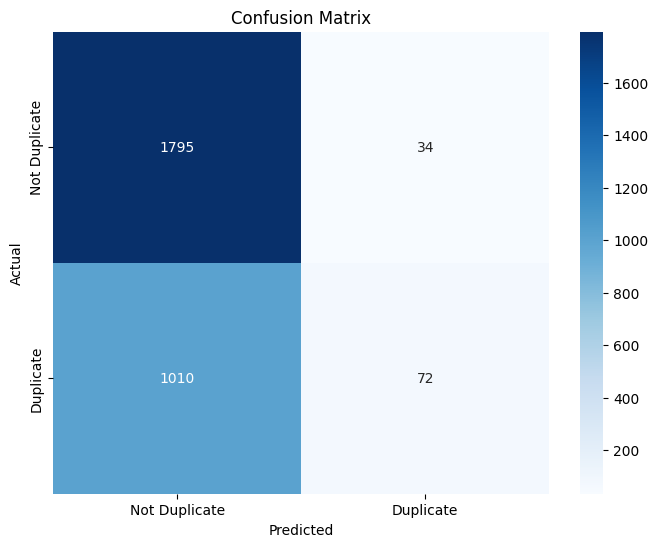

<Axes: >

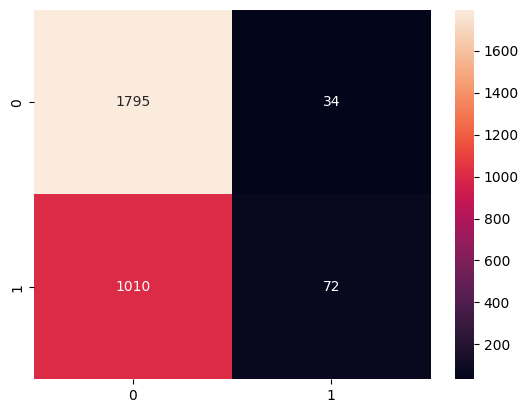

In [0]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Duplicate', 'Duplicate'], yticklabels=['Not Duplicate', 'Duplicate'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d')

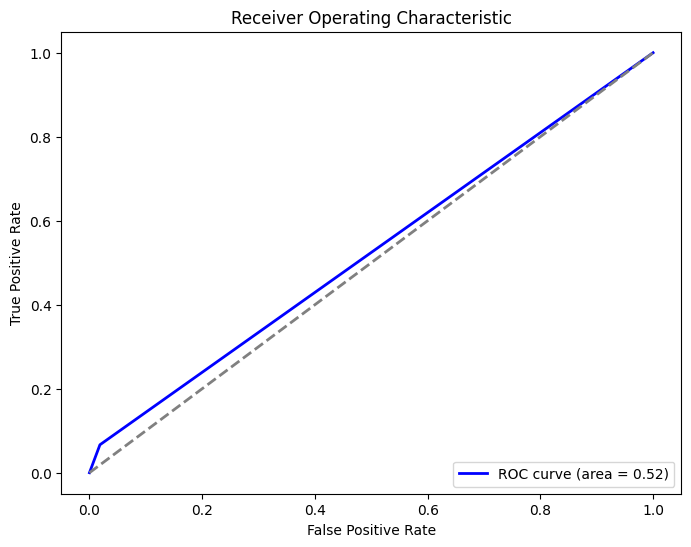

In [0]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()